In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [2]:
import os

!ls /kaggle/input


bhanu-images  bhanu-images2  fashion-product-images-dataset


In [3]:
!ls /kaggle/input/fashion-product-images-dataset
!ls /kaggle/input/fashion-product-images-dataset/fashion-dataset/images | head

fashion-dataset
10000.jpg
10001.jpg
10002.jpg
10003.jpg
10004.jpg
10005.jpg
10006.jpg
10007.jpg
10008.jpg
10009.jpg
ls: write error: Broken pipe


In [4]:
DATA_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset"
df = pd.read_csv(os.path.join(DATA_PATH, "styles.csv"), on_bad_lines='skip')
print(df.head())
print(df.info())

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column         

In [5]:
df = df.dropna(subset=['gender', 'baseColour', 'masterCategory', 'usage'])

In [6]:
IMAGE_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images"
df.dropna(inplace=True)
df['id'] = df['id'].astype(str) + ".jpg"
df = df[df['id'].isin(os.listdir(IMAGE_PATH))]
df.reset_index(drop=True, inplace=True)


In [7]:
print(df['gender'].isna().sum())
print(df['gender'].value_counts())


0
gender
Men       22104
Women     18357
Unisex     2126
Boys        830
Girls       655
Name: count, dtype: int64


<Axes: xlabel='count', ylabel='masterCategory'>

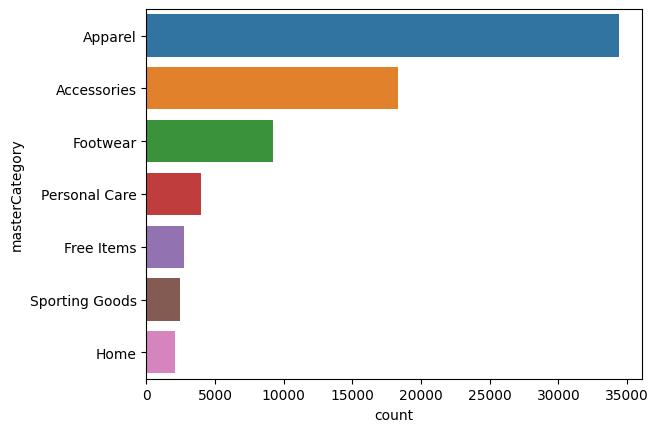

In [8]:
sns.countplot(y='gender', data=df)
sns.countplot(y='baseColour', data=df, order=df['baseColour'].value_counts().iloc[:10].index)
sns.countplot(y='usage', data=df)
sns.countplot(y='masterCategory', data=df)

In [9]:
from sklearn.preprocessing import LabelEncoder

df = df[['id', 'baseColour', 'masterCategory', 'usage', 'gender']]
df.dropna(inplace=True)

le_color = LabelEncoder()
le_type = LabelEncoder()
le_usage = LabelEncoder()
le_gender = LabelEncoder()

df['baseColour'] = le_color.fit_transform(df['baseColour'])
df['masterCategory'] = le_type.fit_transform(df['masterCategory'])
df['usage'] = le_usage.fit_transform(df['usage'])
df['gender'] = le_gender.fit_transform(df['gender'])


In [10]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
class FashionDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, f"{row['id']}")
        if not os.path.exists(img_path):
            print(f"[Missing Image] {img_path}")
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        labels = {
            'baseColour': row['baseColour'],
            'masterCategory': row['masterCategory'],
            'usage': row['usage'],
            'gender': row['gender'],
        }

        return image, labels


In [11]:
import torch
from torch.utils.data import DataLoader
IMAGE_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images"


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

#dataset = FashionDataset(df, IMAGE_PATH, transform=transform)
#train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
subset_df = df.sample(1000, random_state=42)
dataset = FashionDataset(subset_df, IMAGE_PATH, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)



In [12]:
import torch.nn as nn
import torchvision.models as models

class MultiOutputModel(nn.Module):
    def __init__(self, n_color, n_type, n_usage, n_gender):
        super(MultiOutputModel, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Identity()
        self.fc_color = nn.Linear(512, n_color)
        self.fc_type = nn.Linear(512, n_type)
        self.fc_usage = nn.Linear(512, n_usage)
        self.fc_gender = nn.Linear(512, n_gender)

    def forward(self, x):
        x = self.base_model(x)
        return {
            'baseColour': self.fc_color(x),
            'masterCategory': self.fc_type(x),
            'usage': self.fc_usage(x),
            'gender': self.fc_gender(x)
        }


In [13]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiOutputModel(
    n_color=len(le_color.classes_),
    n_type=len(le_type.classes_),
    n_usage=len(le_usage.classes_),
    n_gender=len(le_gender.classes_)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(5):  # Increase for better results
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = {k: v.to(device) for k, v in labels.items()}
        outputs = model(images)

        loss = sum(criterion(outputs[k], labels[k]) for k in outputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 | Loss: 4.7045
Epoch 2 | Loss: 2.2044
Epoch 3 | Loss: 1.3671
Epoch 4 | Loss: 2.5023
Epoch 5 | Loss: 1.1097


In [14]:
def predict_image(model, image_path):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)

    return {
        "Color": le_color.inverse_transform([outputs['baseColour'].argmax().item()])[0],
        "Type": le_type.inverse_transform([outputs['masterCategory'].argmax().item()])[0],
        "Usage": le_usage.inverse_transform([outputs['usage'].argmax().item()])[0],
        "Gender": le_gender.inverse_transform([outputs['gender'].argmax().item()])[0]
    }

# print(predict_image(model, "/kaggle/input/bhanu-images/images/10006.jpg"))
image_folder = "/kaggle/input/bhanu-images2/Kaggle_images"
image_files = os.listdir(image_folder)

for file in image_files:
    file_path = os.path.join(image_folder, file)
    result = predict_image(model, file_path)
    print(f"Prediction for {file}: {result}")


Prediction for abbayyi.webp: {'Color': 'Red', 'Type': 'Apparel', 'Usage': 'Formal', 'Gender': 'Men'}
Prediction for shopping.webp: {'Color': 'Blue', 'Type': 'Apparel', 'Usage': 'Casual', 'Gender': 'Men'}
Prediction for ammayyi.webp: {'Color': 'Blue', 'Type': 'Apparel', 'Usage': 'Casual', 'Gender': 'Women'}
Prediction for 61w166TszBL.jpg: {'Color': 'Blue', 'Type': 'Apparel', 'Usage': 'Casual', 'Gender': 'Men'}
Prediction for pure.webp: {'Color': 'White', 'Type': 'Apparel', 'Usage': 'Casual', 'Gender': 'Men'}


In [15]:
import os

base_path = "/kaggle/input/bhanu-images2"
for root, dirs, files in os.walk(base_path):
    print("Current Directory:", root)
    print("Sub-directories:", dirs)
    print("Files:", files)
    print("-" * 50)


Current Directory: /kaggle/input/bhanu-images2
Sub-directories: ['Kaggle_images']
Files: []
--------------------------------------------------
Current Directory: /kaggle/input/bhanu-images2/Kaggle_images
Sub-directories: []
Files: ['abbayyi.webp', 'shopping.webp', 'ammayyi.webp', '61w166TszBL.jpg', 'pure.webp']
--------------------------------------------------


In [16]:
import torch
torch.save(model, "fashion_model_full.pth")


In [17]:
from IPython.display import FileLink

# This creates a clickable link in notebook to download the file
FileLink('/kaggle/working/fashion_model_full.pth')


/kaggle/working/fashion_model_full.pth

In [20]:
torch.save(le_color, "le_color.pt")
torch.save(le_type, "le_type.pt")
torch.save(le_usage, "le_usage.pt")
torch.save(le_gender, "le_gender.pt")